In [44]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import curve_fit

from typing import Literal, Union

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl

from qs_mps.utils import create_sequential_colors, load_list_of_lists, anim, get_cx, get_cy, von_neumann_entropy
from qs_mps.mps_class import MPS

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

font = {'family': 'serif', 'size': 20}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

model = "Z2_dual"
path = "marcos"
# path = "pc"
cx = [3,37]
cy = [3,3]
# cx = None
# cy = None

if model == "Ising":
    model_path = "0_ISING"

elif model == "Z2_dual":
    model_path = "1_Z2"
    param_label = "h"
    boundcond = "obc"
    if cx == None:
        sector = "vacuum_sector"
    else:
        sector = f"{len(cx)}_particle(s)_sector"

elif model == "ANNNI":
    model_path = "2_ANNNI"

elif model == "Cluster":
    model_path = "3_CLUSTER"
else:
    raise SyntaxError("Model not valid. Choose among 'Ising', 'Z2', 'ANNNI', 'Cluster'")
# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
if path == "pc":
    path_tensor = f"C:/Users/HP/Desktop/projects/1_Z2"
    parent_path = path_tensor
    path_figures = "G:/My Drive/projects/1_Z2"

    # parent_path = "G:/My Drive/projects/1_Z2"
    # path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    # parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    parent_path = path_tensor
elif path == "marcos":
    path_figures = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Quantum Mutual Information

Let us get a quantum state in mps form and get the reduced density matrix relative to a particular column.
Compute the entropy with it and then trace out the parts of the column to isolate and compute again the entropies of the relative parts. Sum the two entropies of the subsystem and subtract with the initial entropy of the column.

In [39]:
L = 5
l = 6
chi = 16
h = 0.7
bc = "pbc"

precision = 2
mps = MPS(L=L, d=2**l, model="Z2_dual", chi=chi, h=h, bc=bc)
sector_vac = "vacuum_sector"
cx_vac = np.nan
cy_vac = np.nan
if sector_vac != "vacuum_sector":
    mps.Z2.add_charges(cx_vac, cy_vac)
    mps.charges = mps.Z2.charges
    mps.Z2._define_sector()
else:
    mps.Z2._define_sector()

try:
    mps.load_sites(
        path=path_tensor, precision=precision, cx=cx_vac, cy=cy_vac
    )
    print("State found!!")
except:
    print("State not found! Computing DMRG")
    mps._random_state(seed=3, type_shape="rectangular", chi=chi)
    mps.canonical_form()
    mps.sites.append(np.random.rand(1,2,1))
    mps.L = len(mps.sites)
    energy, entropy, schmidt_vals, t_dmrg = mps.DMRG(trunc_chi=True, trunc_tol=False, where=L//2, long="Z", trans="X")
    mps.check_canonical(site=1)
    aux_qub = mps.sites.pop()
    mps.L -= 1

    mps.order_param()
    mag = mps.mpo_first_moment()
    print(f"initial magentization is: {mag}")

    # mps.sites = [tensor.astype(np.complex128) for tensor in mps.sites]
    mps.save_sites(path=path_tensor, precision=precision, cx=cx_vac, cy=cy_vac)

State not found! Computing DMRG
Sweep n: 0

Sweep n: 1

the tensor at site 6 is in the correct RFC
the tensor at site 5 is in the correct RFC
the tensor at site 4 is in the correct RFC
the tensor at site 3 is in the correct RFC
the tensor at site 2 is in the correct RFC
initial magentization is: (25.41024010438898+0j)
time for saving: 0:00:00.040443


In [40]:
rdm_mid = mps.reduced_density_matrix(sites=[L//2])
rdm_mid.shape

(64, 64)

In [41]:
from scipy.linalg import logm
(rdm_mid @ logm(rdm_mid)).trace()

(-0.05184729386142012+0j)

Now we need to trace out the spins we want in the column and find their entropy

In [42]:
from ncon import ncon
rdm_tensor = rdm_mid.reshape(tuple([2]*(2*l)))

indices1 = [-1] + np.arange(1,l-1).tolist() + [-2]  +  [-3] + np.arange(1,l-1).tolist() + [-4]
indices2 = [1] + (-np.arange(1,l-1)).tolist() + [2]  +  [1] + (-np.arange(l-1, 2*(l-2)+1)).tolist() + [2]
area1 = ncon([rdm_tensor],[indices1]).reshape((2**2,2**2))
area2 = ncon([rdm_tensor],[indices2]).reshape((2**(l-2),2**(l-2)))

In [ ]:
def quantum_mutual_information(A,B,AB):
    return von_neumann_entropy(A,dm=True) + von_neumann_entropy(B,dm=True) - von_neumann_entropy(AB,dm=True)

In [43]:
mutual_info = (area1 @ logm(area1)).trace() + (area1 @ logm(area1)).trace() - (rdm_mid @ logm(rdm_mid)).trace()
mutual_info

(0.0016564166019905069+0j)

## Quantify Quench

In [57]:
h_i, h_f, npoints = 0.4, 5.0, 33
gs = np.linspace(h_i,h_f,npoints)
gs = [0.1,0.725,2.0]
l = 4

L = 30
d = 2**l
chi = 128
Rs = [14,16,18,20]
R = 20
bc = "pbc"

cx = get_cx(L,R)
cy = get_cy(l,bc)

bond = True
where = L//2

energy_diff = []
fid = []
for g in gs:
    print("====================")
    print(f"g: {g}\n\n")
    lattice_mps = MPS(
                    L=L, d=d, model=model, chi=chi, h=g, bc=bc
                    )
    sector_vac = "vacuum_sector"
    cx_vac = np.nan
    cy_vac = np.nan
    if sector_vac != "vacuum_sector":
        lattice_mps.Z2.add_charges(cx_vac, cy_vac)
        lattice_mps.charges = lattice_mps.Z2.charges
        lattice_mps.Z2._define_sector()
    else:
        lattice_mps.Z2._define_sector()
    try:
        lattice_mps.load_sites(
            path=path_tensor, precision=2, cx=cx_vac, cy=cy_vac
        )
        print("State found!!")
        precision = 2
        if bond:
            lattice_mps.canonical_form(svd_direction="right", trunc_chi=False, trunc_tol=True, schmidt_tol=1e-15)
            entropy = von_neumann_entropy(lattice_mps.bonds[L//2])
            print("Entropy of initial state for the middle MPS bond")
            print(entropy)
        else:
            lattice_mps.canonical_form(svd_direction="right", trunc_chi=False, trunc_tol=True, schmidt_tol=1e-15)
            entropy = [von_neumann_entropy(lattice_mps.bonds[i]) for i in range(L-1)]
            print("Entropy of initial state for all of the MPS bonds")
            print(entropy)
    except:
        try:
            for precision in range(1,4):
                try:
                    lattice_mps.load_sites(
                        path=path_tensor, precision=precision, cx=cx_vac, cy=cy_vac
                    )
                    print("State found!!")
                    if bond:
                        lattice_mps.canonical_form(svd_direction="right", trunc_chi=False, trunc_tol=True, schmidt_tol=1e-15)
                        entropy = von_neumann_entropy(lattice_mps.bonds[L//2])
                        print("Entropy of initial state for the middle MPS bond")
                        print(entropy)
                    else:
                        lattice_mps.canonical_form(svd_direction="right", trunc_chi=False, trunc_tol=True, schmidt_tol=1e-15)
                        entropy = [von_neumann_entropy(lattice_mps.bonds[i]) for i in range(L-1)]
                        print("Entropy of initial state for all of the MPS bonds")
                        print(entropy)
                    break
                except:
                    print(f"State not found! Changing precison: {precision}")
        except:
                print("State not found! Computing DMRG")
                lattice_mps._random_state(seed=3, type_shape="rectangular", chi=chi)
                lattice_mps.canonical_form()
                lattice_mps.sites.append(np.random.rand(1,2,1))
                lattice_mps.L = len(lattice_mps.sites)
                energy, entropy, schmidt_vals, t_dmrg = lattice_mps.DMRG(trunc_chi=True, trunc_tol=False, bond=False)
                lattice_mps.check_canonical(site=1)
                aux_qub = lattice_mps.sites.pop()
                lattice_mps.L -= 1

                lattice_mps.order_param()
                mag = lattice_mps.mpo_first_moment()
                print(f"initial magentization is: {mag}")

                lattice_mps.save_sites(path=path_tensor, precision=precision, cx=cx_vac, cy=cy_vac)

    if sector != "vacuum_sector":
        lattice_mps.Z2.add_charges(cx, cy)
        lattice_mps.charges = lattice_mps.Z2.charges
        lattice_mps.Z2._define_sector()
    else:
        lattice_mps.Z2._define_sector()

    lattice_mps.chi = chi

    # quantify quench
    print("==============================")
    print("Quantify the quench")
    lattice_mps.sites.append(aux_qub)
    lattice_mps.L = len(lattice_mps.sites)
    lattice_mps.mpo()
    E_init = lattice_mps.mpo_first_moment().real
    aux_qub = lattice_mps.sites.pop()
    lattice_mps.L -= 1


    mps_gs_quench = MPS(
            L=L, d=d, model=model, chi=chi, h=g, bc=bc
        )

    if sector != "vacuum_sector":
        mps_gs_quench.Z2.add_charges(cx, cy)
        mps_gs_quench.charges = mps_gs_quench.Z2.charges
        mps_gs_quench.Z2._define_sector()
    else:
        mps_gs_quench.Z2._define_sector()
    try:
        for precision in range(1,4):
            try:
                mps_gs_quench.load_sites(
                    path=path_tensor, precision=precision, cx=cx, cy=cy
                )
                print("State found!!")
                precision = 2
                if bond:
                    mps_gs_quench.canonical_form(svd_direction="right", trunc_chi=False, trunc_tol=True, schmidt_tol=1e-15)
                    entropy = von_neumann_entropy(mps_gs_quench.bonds[L//2])
                    print("Entropy of initial state for the middle MPS bond")
                    print(entropy)
                else:
                    mps_gs_quench.canonical_form(svd_direction="right", trunc_chi=False, trunc_tol=True, schmidt_tol=1e-15)
                    entropy = [von_neumann_entropy(mps_gs_quench.bonds[i]) for i in range(L-1)]
                    print("Entropy of initial state for all of the MPS bonds")
                    print(entropy)
                break
            except:
                print(f"State not found! Changing precison: {precision}")
    except:
        print("State not found! Computing DMRG")
        mps_gs_quench._random_state(seed=3, type_shape="rectangular", chi=chi)
        mps_gs_quench.canonical_form()
        mps_gs_quench.sites.append(np.random.rand(1,2,1))
        mps_gs_quench.L = len(mps_gs_quench.sites)
        energy, entropy, schmidt_vals, t_dmrg = mps_gs_quench.DMRG(trunc_chi=True, trunc_tol=False, bond=False)
        mps_gs_quench.check_canonical(site=1)
        aux_qub_quench = mps_gs_quench.sites.pop()
        mps_gs_quench.L -= 1

        mps_gs_quench.order_param()
        mag = mps_gs_quench.mpo_first_moment()
        print(f"initial magentization is: {mag}")

        mps_gs_quench.save_sites(path=path_tensor, precision=precision, cx=cx, cy=cy)

    mps_gs_quench.sites.append(aux_qub)
    mps_gs_quench.L = len(mps_gs_quench.sites)
    mps_gs_quench.mpo()
    E_1 = mps_gs_quench.mpo_first_moment().real
    aux_qub = mps_gs_quench.sites.pop()
    mps_gs_quench.L -= 1

    lattice_mps.ancilla_sites = mps_gs_quench.sites.copy()
    fidelity = lattice_mps._compute_norm(site=1, mixed=True)
    lattice_mps.ancilla_sites = []
    print("Energy of H_1 over psi_0: ",E_init, ", Energy of H_1 over psi_1", E_1)
    print(f"Relative Difference (wrt E_1): {(E_1 - E_init)/E_1} \n\n")
    print(f"Fidelity between the two ground states is: {fidelity}")
    energy_diff.append((E_1 - E_init)/E_1)
    fid.append(abs(fidelity.real))

g: 0.1


Metadata: {'L': 30, 'bc': 'pbc', 'chi': 128, 'cx': nan, 'cy': nan, 'h': 0.1, 'l': 4, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}
State found!!
Entropy of initial state for the middle MPS bond
0.00046841592297637287
Quantify the quench
Metadata: {'L': 30, 'bc': 'pbc', 'chi': 128, 'cx': array([ 5, 25]), 'cy': array([0, 0]), 'h': 0.1, 'l': 4, 'model': 'Z2_dual', 'sector': '2_particle(s)_sector'}
State found!!
Entropy of initial state for the middle MPS bond
0.00046841586262994476
Energy of H_1 over psi_0:  -1200.0349204146798 , Energy of H_1 over psi_1 -1200.063086164937
Relative Difference (wrt E_1): 2.347022467555471e-05 


Fidelity between the two ground states is: (-0.9995438790884033+0j)
g: 0.725


State not found! Changing precison: 1
State not found! Changing precison: 2
Metadata: {'L': 30, 'bc': 'pbc', 'chi': 128, 'cx': nan, 'cy': nan, 'h': 0.725, 'l': 4, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}
State found!!
Entropy of initial state for the middle MPS bond
0.023

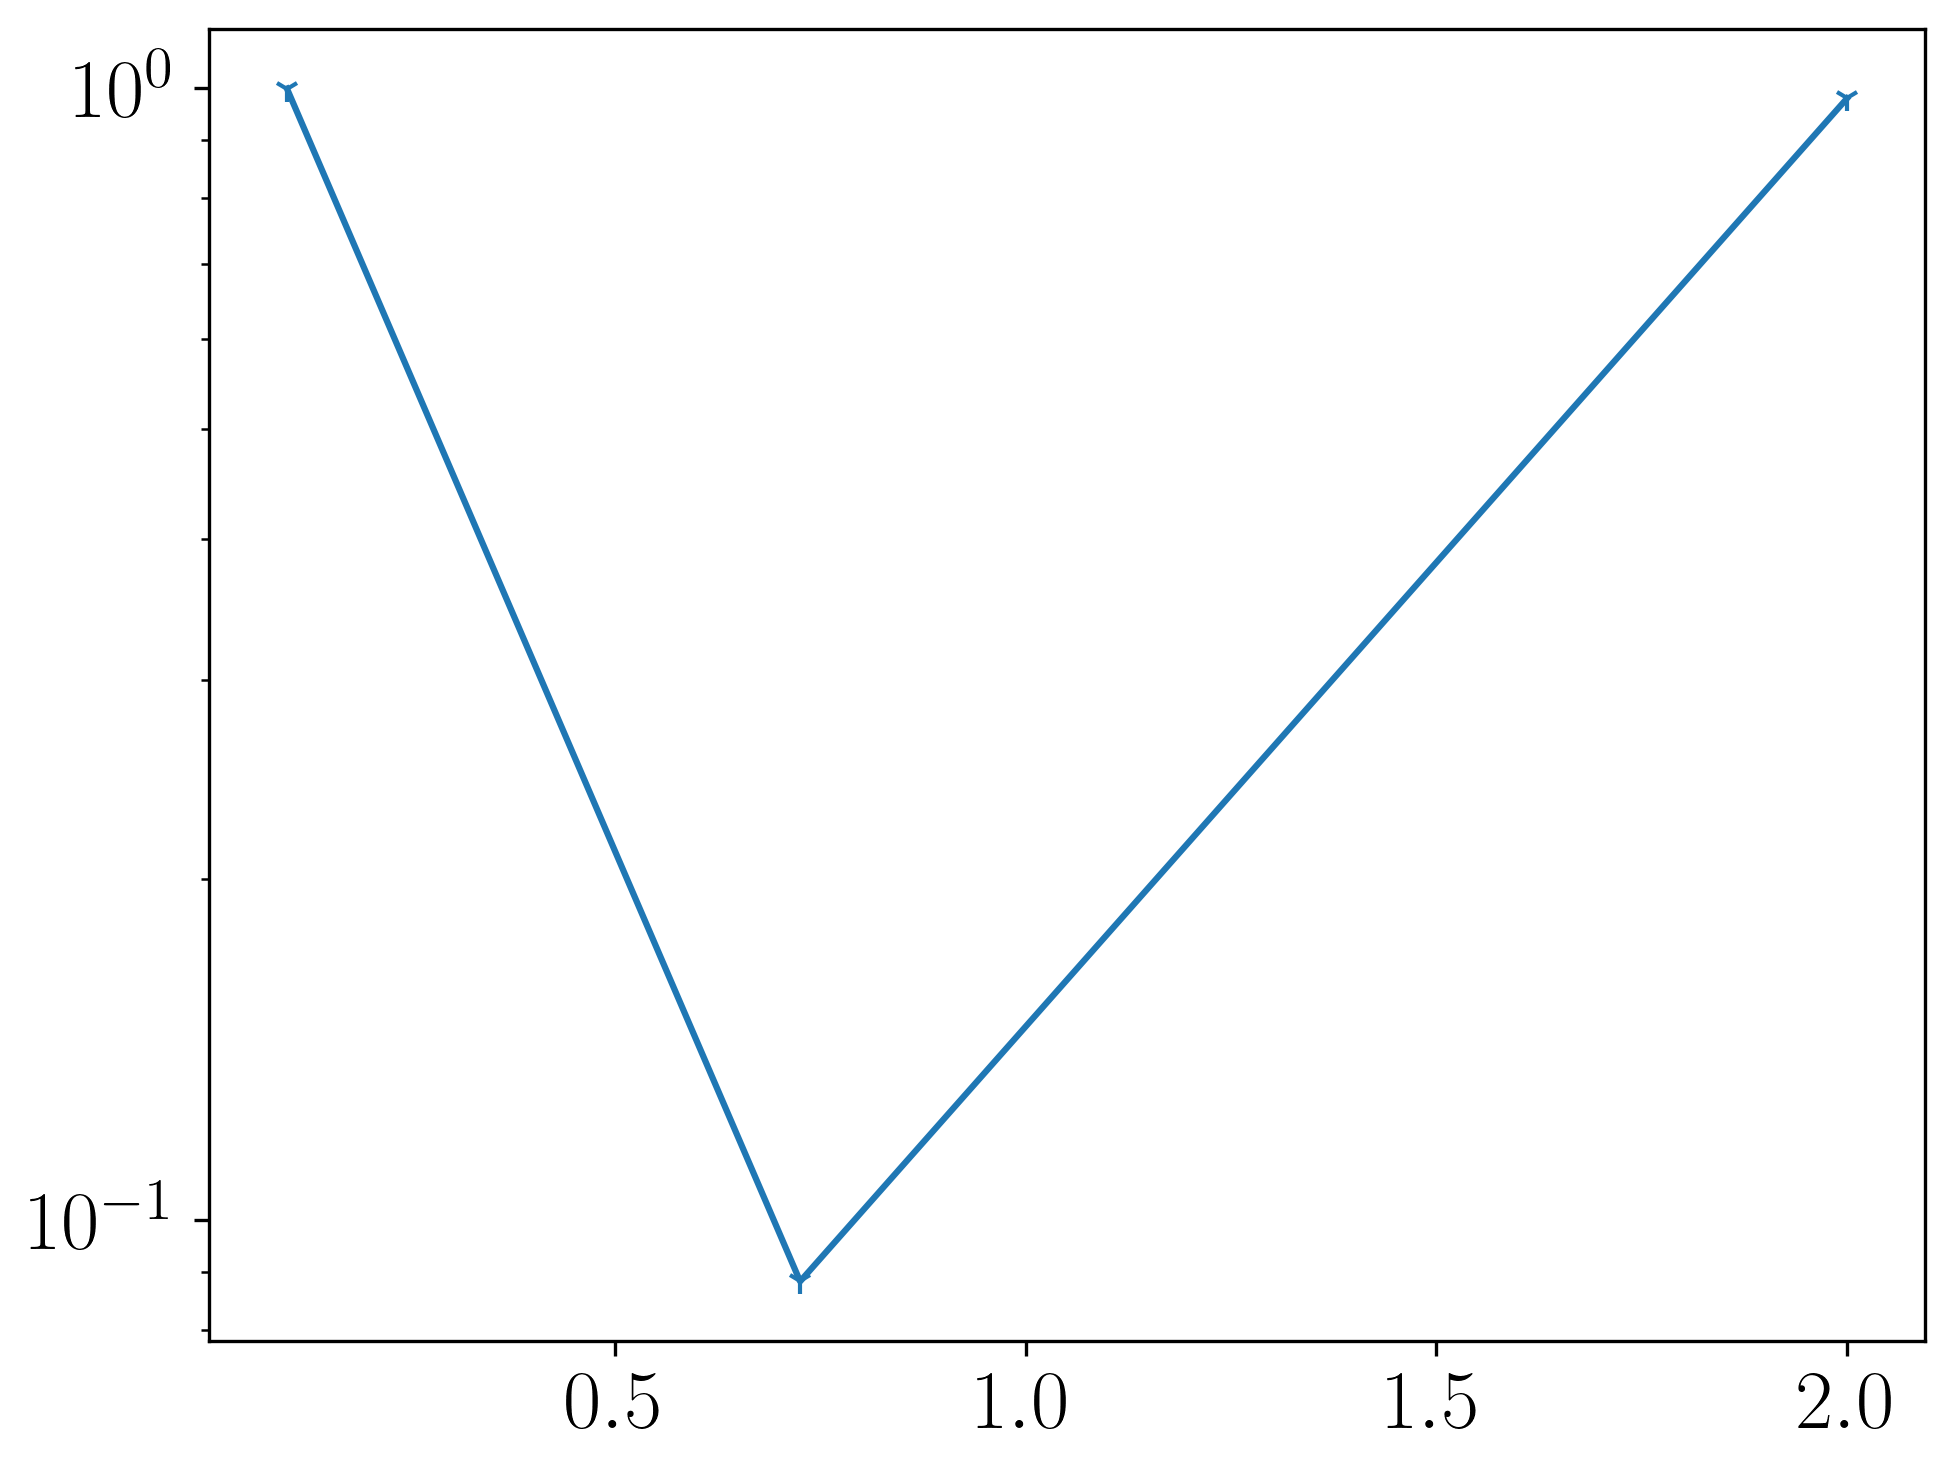

In [58]:
plt.plot(gs, fid, marker="1")
plt.yscale("log")

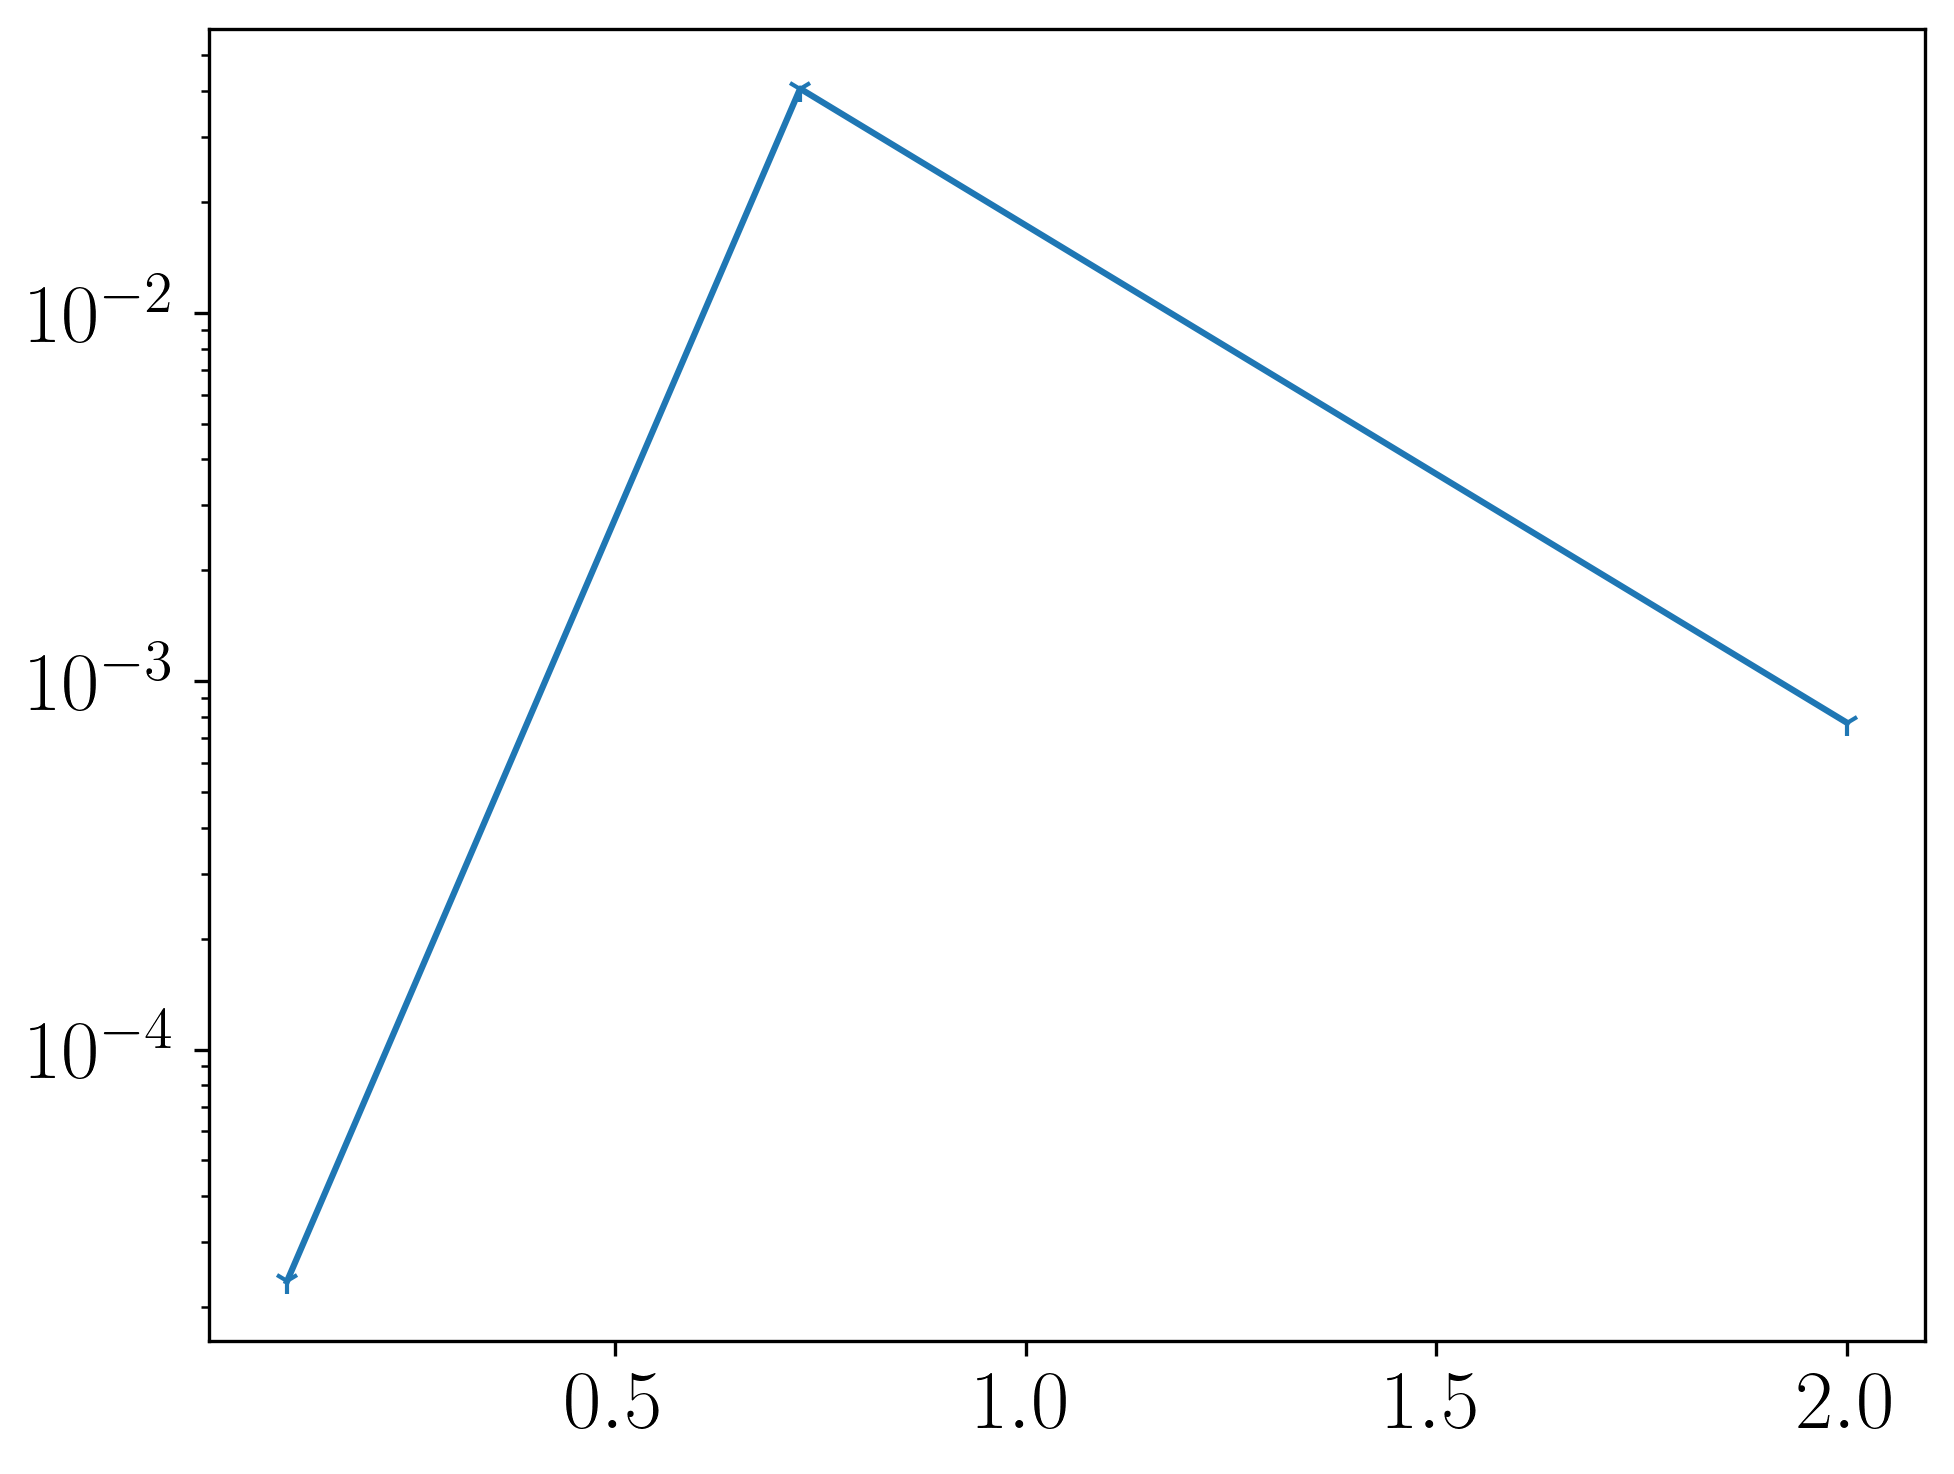

In [59]:
plt.plot(gs, energy_diff, marker="1")
plt.yscale("log")